![](imagenes/UC_FMRI.jpg)

---
---

***Andres Eduardo Aracena Rangel***

*Estudiante del programa del Magister en Física Médica*

---

---

El siguiente Script de Python forma parte del trabajo especial de grado.

Profesora Guía:

*PhD María Daniela Cornejo*

---

---

Imagenes de fMRI extraidas de OpenNuero:

 
- [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)
 
---

# Extracción de craneo en imagenes funcional preprocesada

## Importamos librerias

In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)

import matplotlib.pyplot as plt

import numpy as np
import nibabel as nib
from nilearn.plotting import plot_anat

import pandas as pd

from nipype import Node, Workflow, SelectFiles, IdentityInterface
from nipype.interfaces.io import DataSink
from nipype.interfaces.fsl import BET

/home/aracena/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


220720-01:33:00,27 nipype.utils WARNING:
	 A newer version (1.8.3) of nipy/nipype is available. You are using 1.7.0


## Definimos parametros

In [3]:
'''
Ruta del directorio de la data
'''
path_data = '/home/aracena/thesis_ds002422/' 

'''
Ruta donde reposa la imagen funcional procesada
'''
path_fmri = opj(path_data,'01_fase1_extraccion_mask_brain','output','datasink','fmri_detrend',
                'mask_ext_csf', 'threshold_0.95')

'''
Ruta donde reposan las imagenes de referencia de los cortes anatomicos
'''
path_ref = opj(path_data,'02_fase1_extraccion_brain_fmri_prepro', 'imagenes')

'''
Ruta donde se guardaran los resultados
'''
path_output = opj(path_data,'02_fase1_extraccion_brain_fmri_prepro', 'output')
path_png = opj(path_output,'archivos_png')
               
# Crear la carpeta de salida
os.system('mkdir -p %s'%path_output)
os.system('mkdir -p %s'%path_png);

## Definimos funciones

### Función atributos

In [4]:
'''
Función para extraer los atributos de la(s) imagen(es).

Inputs:

- img: Diccinario con las imagenes nifti

Output:

df_atri: Dataframe con los principales atributos de las imagenes contenidas en el diccionario 'img'
'''

def atributo_img(img):
    import pandas as pd
    lista_img = list(img.keys()) # Creamos una lista con las claves del diccionario

    df_atri = pd.DataFrame()
    df_atri.index = ['forma', 'dimension', 'orientacion', '', 'x_img', 'y_img' , 'z_img', 'volumenes_(N)', 'voxel_size_(mm)', 
                       'TR_(s)', 'tipo_dato', 'numero_voxels','min_img', 'max_img']
    
    for i, ima in enumerate(lista_img):
        lista_atri = []
        #cargamos el header de la imagen
        header_img = img[ima].header
        
        # Forma y dimensión de la imágen
        forma = header_img.get_data_shape() 
        lista_atri.append(str(forma))
        lista_atri.append(len(forma))
        
        # Orientacion de la imágen
        orientacion = nib.orientations.aff2axcodes(img[ima].affine)
        lista_atri.append(orientacion)

        # x, y, z y volumenes
        ejes=[]
        for i in range(len(orientacion)):
            tam = img[ima].shape[i]
            ori = str(orientacion[i])
            if  ori == 'L'or ori == 'R':
                x_img = tam
                a = 'x'

            elif ori == 'A' or ori == 'P':
                y_img = tam
                a = 'y'

            elif ori == 'I'or ori == 'S':
                z_img = tam
                a = 'z'
                
            ejes.append(a)
        
        # Agregamos a la lista de atributos forma, x, y, z
        lista_atri.append(ejes)
        lista_atri.append(x_img)
        lista_atri.append(y_img)
        lista_atri.append(z_img)
        
        # Agregamos volumes a la lista de atributos 
        if len(forma) == 4:
            lista_atri.append(forma[-1])
        else:
            lista_atri.append('1')

        # Tamaño del voxel
        tavo = header_img.get_zooms()[0:3]
        
        tamvox=[]
        for i in range(len(tavo)):
            tamvox.append(round(tavo[i],3))
            
        lista_atri.append(tamvox) 
        
        # Tiempo de exploración
        if len(header_img.get_zooms()) == 4:
            lista_atri.append(header_img.get_zooms()[-1])
        else:
            lista_atri.append('---')     
        
        
        #lista_atri.append(header_img.get_zooms()[-1])   # Tiempo de exploración
        lista_atri.append(header_img.get_data_dtype())   # Tipo de datos numérico
        lista_atri.append(img[ima].get_fdata().size) # Número de elementos de la matriz
        lista_atri.append(round(img[ima].get_fdata().min(),2)) # Valor minimo de la imágen
        lista_atri.append(round(img[ima].get_fdata().max(),2)) # Valor maximo de la imágen
        
        # Creamos DF de atributos de la imagen
        df_at = pd.DataFrame()
        df_at = pd.DataFrame(lista_atri)
        df_at.columns = [ima]
        df_at.index = df_atri.index
        #display(df_at)

        # Unimos las DF
        df_atri = pd.merge(df_atri, df_at,
                           right_index=True,left_index=True)
    return df_atri

### Funcion para visualizar los cortes anatomicos sobre un voxel

In [5]:
'''
Función para generar la visualización de los cortes anatómico de varias imágenes (hasta cuatro) 

Inputs:

- img: Diccionario con las imágenes nifti
- vol: Volumen donde se desea visualizar los cortes anatómicos
- vox: Posición i,j,k del voxel sobre el cual se proyectarán los cortes
#- nom_img = nombre de la imagen con que se desea visualizar y guardar

Outputs:
- plot de los diferentes cortes anatómicos sobre un voxel de las imágenes ingresadas en 'img'
'''

def visual_cortes_ana(img, vol, voxel):
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
   
    # Creamos una lista con las claves del diccionario ingresado
    lista_img = list(img.keys())
    
    corte_sag = {}
    corte_cor = {}
    corte_axi = {}
    datos_img = {}
    x_cor = {}
    y_cor = {}
    z_cor = {}
    nomb_ori={}
    for i, ima in enumerate(lista_img):
        # Orientacion de la imágen
        orientacion = nib.orientations.aff2axcodes(img[ima].affine)
        # creamos un nombre para la grafica
        a = ','.join(orientacion)
        nomb_ori[ima] = '('+ a +')'
        
        #cargamos datos de la imagen
        datos_img[ima] = img[ima].get_fdata()
        ta = len(datos_img[ima].shape)
        if ta == 4:
            datos_img[ima] = datos_img[ima][...,vol]
        else:
            datos_img[ima] = datos_img[ima][...]

        #se extraen valores x, y, z del voxel ingresado y cortes segun posición anatómica
        for j in range(len(orientacion)):
            ori = str(orientacion[j])

            if  ori == 'L'or ori == 'R':
                x_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_sag[ima] = datos_img[ima][x_cor[ima],:,:]
                elif j == 1:
                    corte_sag[ima] = datos_img[ima][:,x_cor[ima],:]
                elif j == 2:
                    corte_sag[ima] = datos_img[ima][:,:,x_cor[ima]]

            elif ori == 'A' or ori == 'P':
                y_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_cor[ima] = datos_img[ima][y_cor[ima],:,:]
                elif j == 1:
                    corte_cor[ima] = datos_img[ima][:,y_cor[ima],:]
                elif j == 2:
                    corte_cor[ima] = datos_img[ima][:,:,y_cor[ima]]

            elif ori == 'I'or ori == 'S':
                z_cor[ima] = voxel[j]
                
                # corte segun posición anatómica
                if j == 0:
                    corte_axi[ima] = datos_img[ima][z_cor[ima],:,:]
                elif j == 1:
                    corte_axi[ima] = datos_img[ima][:,z_cor[ima],:]
                elif j == 2:
                    corte_axi[ima] = datos_img[ima][:,:,z_cor[ima]]
    
    # Definimos estilo de letra para la grafica
    font1 = {'fontsize':18, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    
    if (len(lista_img))==1:
        #Graficamos
        nom = lista_img[0] + '\n' + nomb_ori[lista_img[0]]

        fig, axes = plt.subplots(1,3, figsize=(15, 15))
        fig.suptitle(nom, fontweight ="bold", fontsize = 22, color = 'tab:blue')
        axes[0].imshow(corte_sag[ima], cmap = 'gray')
        axes[1].imshow(corte_cor[ima], cmap = 'gray')
        axes[2].imshow(corte_axi[ima], cmap = 'gray')
        for i in range(3):
            axes[i].axis('off')

        # Titulos de las graficas
        titulo =['Corte Sagital: '+ str(x_cor[ima]) + '\n', 
                 'Corte Coronal: '+ str(y_cor[ima]) + '\n',
                 'Corte Axial: '+ str(z_cor[ima]) + '\n']

        for i, title in enumerate(titulo):
            axes[i].set_title(title, fontdict=font2)

        plt.subplots_adjust(#left=0.5,
                        #bottom=0.5, 
                        #right=0.7,
                        hspace=0.3,
                        top=1.26)
        fig.patch.set_facecolor('xkcd:white')
        plt.show()
    
    else:
        # Graficamos
        fig, axes = plt.subplots(3, len(lista_img),figsize=(20, 20))
        for i, im in enumerate(lista_img):
            axes[0,i].imshow(corte_sag[im], cmap = 'gray')
            axes[1,i].imshow(corte_cor[im], cmap = 'gray')
            axes[2,i].imshow(corte_axi[im], cmap = 'gray')

        
            # Identificamos los cortes
            titulo =['Corte Sagital: '+ str(x_cor[im]) + '\n', 
                     'Corte Coronal: '+ str(y_cor[im]) + '\n',
                     'Corte Axial: '+ str(z_cor[im]) + '\n']

            for j, title in enumerate(titulo):
                axes[j,i].xaxis.set_label_position('top')
                axes[j,i].set_xlabel(title, fontdict=font2)
            

        # Titulos que que identifica la imagen y la orientacion
        for i,im in enumerate(lista_img):
            axes[0,i].set_title((im+'\n'+nomb_ori[im]+'\n'), 
                                fontdict=font1)
        
        #for j in range(3):
            #for i in range(2):
                #axes[j,i].axis('off')

    
        plt.subplots_adjust(#left=0.5,
                            #bottom=0.5, 
                            #right=0.7,        
                            #hspace=0.3,
                            top=0.91)
    plt.show()
    
    # cargamos imagen de referencia de los cortes anatomicos
    img_cor_sag = mpimg.imread(opj(path_ref,'corte_sagital.png'))
    img_cor_cor = mpimg.imread(opj(path_ref,'corte_coronal.png'))
    img_cor_axi = mpimg.imread(opj(path_ref,'corte_axial.png'))

    img_cor = [img_cor_sag,img_cor_cor,img_cor_axi]

    fig, axes = plt.subplots(1,3, figsize=(2,2))
    for i,imco in enumerate(img_cor):
        axes[i].imshow(img_cor[i])
        axes[i].axis('off')

    # para cambiar el espacio entre las subtramas de Matplotlib
    plt.subplots_adjust(left=0, 
                        bottom=0.1,  
                        right=7,  
                        top=0.9,  
                        wspace=1,  
                        hspace=0.4)
    #fig.tight_layout()
    fig.patch.set_facecolor('xkcd:white')
    plt.plot()

### Función zoom

In [6]:
'''
Función para generar un zoom sobre una region de la imagen con un voxel de comparación

Inputs:

- img = Diccinario con las imagenes nifti
- vol = volumen donde se desea visualizar los cortes anatomicos
- tipo = indicar que corte desea visualizar:
            * 'sagital'
            * 'coronal'
            * 'axial'
- corte = numero del corte a visualizar
- ini_verti = valor inicial de la fila del corte seleccionado
- ini_hori = valor inicial de la columna del corte seleccionado
- n = numero de voxels tanto en filas y columnas que se desean para el zoom
- pto = voxel en el corte anatomico para comparar

Outputs:

- plot de las imagenes ingresadas en 'img'
- DF de comparación de valor de voxel en el voxel indicado
'''

def zoom(img, vol, tipo, corte, ini_verti, ini_hori, n):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import matplotlib.patches as patches
    import pandas as pd
    
    
    # Creamos una lista con las claves del diccionario ingresado
    lista_img = list(img.keys())
    
    x_cor = {} ; y_cor = {} ; z_cor = {}
    corte_sag = {} ; corte_cor = {} ; corte_axi = {}     
    datos_ori={} ; datos_img = {}
    orientacion={}
    nomb_ori={}
            
    for i, ima in enumerate(lista_img):
        # Orientacion de la imágen
        orientacion[ima] = nib.orientations.aff2axcodes(img[ima].affine)
        # creamos un nombre para la grafica
        a = ','.join(orientacion[ima])
        nomb_ori[ima] = '('+ a +')'
        
        #cargamos datos de la imagen
        datos_img[ima] = img[ima].get_fdata()
        ta = len(datos_img[ima].shape)
        if ta == 4:
            datos_img[ima] = datos_img[ima][...,vol]
        else:
            datos_img[ima] = datos_img[ima][...]

        #se extraen valores x, y, z del voxel ingresado y cortes segun posición anatómica
        for j in range(len(orientacion[ima])):
            ori = str(orientacion[ima][j])

            if  ori == 'L'or ori == 'R':                
                # corte segun posición anatómica
                if j == 0:
                    corte_sag[ima] = datos_img[ima][corte,:,:]
                elif j == 1:
                    corte_sag[ima] = datos_img[ima][:,corte,:]
                elif j == 2:
                    corte_sag[ima] = datos_img[ima][:,:,corte]

            elif ori == 'A' or ori == 'P':                
                # corte segun posición anatómica
                if j == 0:
                    corte_cor[ima] = datos_img[ima][corte,:,:]
                elif j == 1:
                    corte_cor[ima] = datos_img[ima][:,corte,:]
                elif j == 2:
                    corte_cor[ima] = datos_img[ima][:,:,corte]

            elif ori == 'I'or ori == 'S':
                # corte segun posición anatómica
                if j == 0:
                    corte_axi[ima] = datos_img[ima][corte,:,:]
                elif j == 1:
                    corte_axi[ima] = datos_img[ima][:,corte,:]
                elif j == 2:
                    corte_axi[ima] = datos_img[ima][:,:,corte]


    # Extraemos el corte segun el tipo
    corte_anat={} ; datos_zoom = {}
    for i, ima in enumerate(lista_img):
        if tipo  == 'sagital':
            corte_anat[ima] = corte_sag[ima]
            datos_zoom[ima] = corte_sag[ima][ini_verti : ini_verti+n,
                                        ini_hori : ini_hori+n]
        if tipo == 'coronal':
            corte_anat[ima] = corte_cor[ima]
            datos_zoom[ima] = corte_cor[ima][ini_verti : ini_verti+n,
                                        ini_hori : ini_hori+n]
        if tipo == 'axial':
            corte_anat[ima] = corte_axi[ima]
            datos_zoom[ima] = corte_axi[ima][ini_verti: ini_verti+n,
                                        ini_hori : ini_hori+n]
            
    # Graficamos
    font1 = {'fontsize':16, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, axes = plt.subplots(len(datos_img),len(datos_img), figsize=(15, 15))
    nom_prin = 'Cortes ' +tipo+'es: '+ str(corte)
    fig.suptitle(nom_prin,fontweight ="bold", fontsize = 22, color = 'tab:blue')
    
    for j,im in enumerate(lista_img):
        axes[j,0].imshow(corte_anat[im], cmap = 'gray')
        axes[j,1].imshow(datos_zoom[im], cmap = 'gray')

        # Nombramos las imagenes        
        axes[j,0].xaxis.set_label_position('top')
        axes[j,0].set_xlabel(im+' '+ nomb_ori[ima] + '\n', fontdict=font2)
        axes[j,1].xaxis.set_label_position('top')
        axes[j,1].set_xlabel('zoom: '+im + '\n', fontdict=font2)

        # Recuadro que identifica la zona del zoom
        cua_1 = patches.Rectangle((ini_hori,ini_verti),n,n, linewidth=2, edgecolor = 'yellow', fill=False)
        axes[j,0].add_patch(cua_1)

        #resaltamos borde de la imagen zoom
        axes[j,1].spines['bottom'].set_color('yellow') ; axes[j,1].spines['bottom'].set_linewidth(10)
        axes[j,1].spines['top'].set_color('yellow') ; axes[j,1].spines['top'].set_linewidth(10)
        axes[j,1].spines['left'].set_color('yellow') ; axes[j,1].spines['left'].set_linewidth(10)
        axes[j,1].spines['right'].set_color('yellow') ; axes[j,1].spines['right'].set_linewidth(10)
        
        
    #display(df_compara.T)
    plt.subplots_adjust(#left=0.5,
                        #bottom=0.5, 
                        #right=0.7,        
                        #hspace=0.3,
                        top=0.92)

### Función Zoom con voxel de comparación

In [7]:
'''
Función para generar un zoom sobre una region de la imagen con un voxel de comparación

Inputs:

- img = Diccinario con las imagenes nifti
- vol = volumen donde se desea visualizar los cortes anatomicos
- tipo = indicar que corte desea visualizar:
            * 'sagital'
            * 'coronal'
            * 'axial'
- corte = numero del corte a visualizar
- ini_verti = valor inicial de la fila del corte seleccionado
- ini_hori = valor inicial de la columna del corte seleccionado
- n = numero de voxels tanto en filas y columnas que se desean para el zoom
- pto = voxel en el corte anatomico para comparar

Outputs:

- plot de las imagenes ingresadas en 'img'
- DF de comparación de valor de voxel en el voxel indicado
'''

def zoom_with_pto(img, vol, tipo, corte, ini_verti, ini_hori, n, pto):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import matplotlib.patches as patches
    import pandas as pd
    
    
    # Creamos una lista con las claves del diccionario ingresado
    lista_img = list(img.keys())
    
    x_cor = {} ; y_cor = {} ; z_cor = {}
    corte_sag = {} ; corte_cor = {} ; corte_axi = {}     
    datos_ori={} ; datos_img = {}
    orientacion={}
    nomb_ori={}


            
    for i, ima in enumerate(lista_img):
        # Orientacion de la imágen
        orientacion[ima] = nib.orientations.aff2axcodes(img[ima].affine)
        # creamos un nombre para la grafica
        a = ','.join(orientacion[ima])
        nomb_ori[ima] = '('+ a +')'
        
        #cargamos datos de la imagen
        datos_img[ima] = img[ima].get_fdata()
        ta = len(datos_img[ima].shape)
        if ta == 4:
            datos_img[ima] = datos_img[ima][...,vol]
        else:
            datos_img[ima] = datos_img[ima][...]

        #se extraen valores x, y, z del voxel ingresado y cortes segun posición anatómica
        for j in range(len(orientacion[ima])):
            ori = str(orientacion[ima][j])

            if  ori == 'L'or ori == 'R':                
                # corte segun posición anatómica
                if j == 0:
                    corte_sag[ima] = datos_img[ima][corte,:,:]
                elif j == 1:
                    corte_sag[ima] = datos_img[ima][:,corte,:]
                elif j == 2:
                    corte_sag[ima] = datos_img[ima][:,:,corte]

            elif ori == 'A' or ori == 'P':                
                # corte segun posición anatómica
                if j == 0:
                    corte_cor[ima] = datos_img[ima][corte,:,:]
                elif j == 1:
                    corte_cor[ima] = datos_img[ima][:,corte,:]
                elif j == 2:
                    corte_cor[ima] = datos_img[ima][:,:,corte]

            elif ori == 'I'or ori == 'S':
                # corte segun posición anatómica
                if j == 0:
                    corte_axi[ima] = datos_img[ima][corte,:,:]
                elif j == 1:
                    corte_axi[ima] = datos_img[ima][:,corte,:]
                elif j == 2:
                    corte_axi[ima] = datos_img[ima][:,:,corte]


    # Extraemos el corte segun el tipo
    corte_anat={} ; datos_zoom = {}
    for i, ima in enumerate(lista_img):
        if tipo  == 'sagital':
            corte_anat[ima] = corte_sag[ima]
            datos_zoom[ima] = corte_sag[ima][ini_verti : ini_verti+n,
                                        ini_hori : ini_hori+n]
        if tipo == 'coronal':
            corte_anat[ima] = corte_cor[ima]
            datos_zoom[ima] = corte_cor[ima][ini_verti : ini_verti+n,
                                        ini_hori : ini_hori+n]
        if tipo == 'axial':
            corte_anat[ima] = corte_axi[ima]
            datos_zoom[ima] = corte_axi[ima][ini_verti: ini_verti+n,
                                        ini_hori : ini_hori+n]
            
    # Graficamos
    font1 = {'fontsize':16, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, axes = plt.subplots(len(datos_img),len(datos_img), figsize=(15, 15))
    nom_prin = 'Cortes ' +tipo+'es: '+ str(corte)
    fig.suptitle(nom_prin,fontweight ="bold", fontsize = 22, color = 'tab:blue')
    
    for j,im in enumerate(lista_img):
        axes[j,0].imshow(corte_anat[im], cmap = 'gray')
        axes[j,1].imshow(datos_zoom[im], cmap = 'gray')

        # Nombramos las imagenes        
        axes[j,0].xaxis.set_label_position('top')
        axes[j,0].set_xlabel(im+' '+ nomb_ori[ima] + '\n', fontdict=font2)
        axes[j,1].xaxis.set_label_position('top')
        axes[j,1].set_xlabel('zoom: '+im + '\n', fontdict=font2)

        # Recuadro que identifica la zona del zoom
        cua_1 = patches.Rectangle((ini_hori,ini_verti),n,n, linewidth=2, edgecolor = 'yellow', fill=False)
        axes[j,0].add_patch(cua_1)

        #resaltamos borde de la imagen zoom
        axes[j,1].spines['bottom'].set_color('yellow') ; axes[j,1].spines['bottom'].set_linewidth(10)
        axes[j,1].spines['top'].set_color('yellow') ; axes[j,1].spines['top'].set_linewidth(10)
        axes[j,1].spines['left'].set_color('yellow') ; axes[j,1].spines['left'].set_linewidth(10)
        axes[j,1].spines['right'].set_color('yellow') ; axes[j,1].spines['right'].set_linewidth(10)
        
    # Graficamos el punto
    for i,im in enumerate(lista_img):
        axes[i,0].scatter(pto[1], pto[0], 
                          marker="s", edgecolor='white', linewidth=2, color='red', s=40)
        axes[i,1].scatter(pto[1]-ini_hori, pto[0]-ini_verti, 
                          marker="s", edgecolor='white', linewidth=2, color='red', s=1200)
    
    
    # DF de comparación del valor del voxel
    df_compara = pd.DataFrame()
    df_compara.index = ['orientacion', 'x', 'y' , 'z', 
                        'volumen', 'valor_voxel']  
    
    for i, ima in enumerate(lista_img):
        lista_at = []
        
        if  ( (orientacion[ima][0] == 'L'or orientacion[ima][0] == 'R') and 
             (orientacion[ima][1] == 'A'or orientacion[ima][1] == 'P') and 
             (orientacion[ima][2] == 'I'or orientacion[ima][2] == 'S') ): 
            
            if tipo  == 'sagital':
                x=corte ; y=pto[0] ; z=pto[1]
            elif tipo == 'coronal':
                x=pto[0] ; y=corte ; z=pto[1]                
            elif tipo == 'axial':
                x=pto[0] ; y=pto[1] ; z=corte

            if len(img[ima].shape) == 4:
                volumen = vol
                valor_voxel = img[ima].get_fdata()[x,y,z,vol]            
            else:
                volumen = '0'
                valor_voxel = img[ima].get_fdata()[x,y,z]
                
        if  ( (orientacion[ima][0] == 'A'or orientacion[ima][0] == 'P') and 
             (orientacion[ima][1] == 'I'or orientacion[ima][1] == 'S') and 
             (orientacion[ima][2] == 'L'or orientacion[ima][2] == 'R') ): 
            if tipo  == 'sagital':
                y=pto[0] ; z=pto[1] ; x=corte
            elif tipo == 'coronal':
                y=corte ; z=pto[0]; x=pto[1]                 
            elif tipo == 'axial':
                y=pto[0] ; z=corte ; x=pto[1] 
            if len(img[ima].shape) == 4:
                volumen = vol
                valor_voxel = img[ima].get_fdata()[y,z,x,vol]            
            else:
                volumen = '0'
                valor_voxel = img[ima].get_fdata()[y,z,x]
       
        # Agregamos valores a la lista
        lista_at.append(nomb_ori[ima])
        lista_at.extend([x,y,z])
        lista_at.append(volumen)
        lista_at.append(valor_voxel)
        
        # Creamos DF de la lista_at
        df_at = pd.DataFrame()
        df_at = pd.DataFrame(lista_at)
        df_at.columns = [ima]
        df_at.index = df_compara.index
        #display(df_at)

        # Unimos las DF
        df_compara = pd.merge(df_compara, df_at,
                           right_index=True,left_index=True)
        
    #display(df_compara.T)
    plt.subplots_adjust(#left=0.5,
                        #bottom=0.5, 
                        #right=0.7,        
                        #hspace=0.3,
                        top=0.9)
    return df_compara.T

## Cargamos imagen y datos de la imagen funcional preprocesada

In [8]:
img_func = 'fmri_rest_prepro.nii.gz'
img_func_orig = nib.load(opj(path_fmri,img_func)) # Cargamos imagen nifti
datos_func_orig = img_func_orig.get_fdata()       # Cargamos datos de la imagen

## Extraemos un volumen de la imagen funcional para procesar

In [9]:
vol = 0
img_func_pre = img_func_orig.slicer[...,vol]
img_func_pre.shape

(62, 62, 44)

In [10]:
'''
Guardamos volumen extraido
'''

name_save = 'fmri_prepro_vol_'+str(vol)
nib.save(img_func_pre, opj(path_output ,name_save +'.nii.gz'))

## Definimos interface BET

In [11]:
new_name_save = 'fmri_prepro_bet_vol_'+str(vol)
skullstrip = BET(in_file = opj(path_output,name_save +'.nii.gz'),
                 out_file = opj(path_output,new_name_save),
                 mask=True)
res = skullstrip.run()

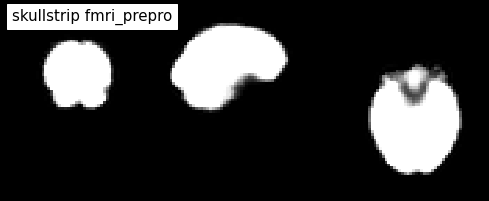

In [12]:
plot_anat(opj(path_output,new_name_save + '.nii.gz'), title='skullstrip fmri_prepro',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

## Convolucionamos

### Cargamos la imagen y datos de la mascara binaria de img_prepro

In [13]:
'''
Al ejecutar la interface BET, me genera una imagen binaria de la extración del cerebro,
con el nombre de la imagen guardada mas la palabra 'mask'
'''

img_func_bi = new_name_save+'_mask'
img_func_bin = nib.load(opj(path_output,img_func_bi+'.nii.gz')) # Cargamos imagen nifti
datos_func_bin = img_func_bin.get_fdata()       # Cargamos datos de la imagen

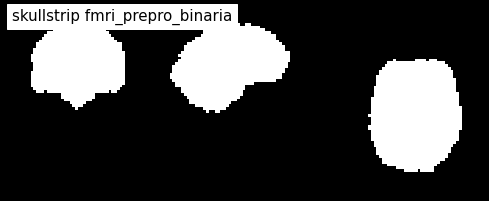

In [14]:
plot_anat(img_func_bin, title='skullstrip fmri_prepro_binaria',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

### Convolucionamos

In [15]:
'''
Copiamos datos de la imagen original
'''
datos_func_bet = np.copy(datos_func_orig)
datos_func_bet.shape

(62, 62, 44, 196)

In [16]:
'''
Convolucionamos con la mascara binaria
'''
for i in range(datos_func_bet.shape[3]):
    datos_func_bet[:,:,:,i] = datos_func_bet[:,:,:,i]*datos_func_bin

datos_func_bet.shape


'''
Guardamos la convolucion
'''
#creamos una imagen nifti, agregamos el header de la ingen funcional preporcesada original
header = img_func_orig.header
affine = img_func_orig.affine

img_new = nib.Nifti1Image(datos_func_bet,affine, header)
nib.save(img_new, opj(path_output, 'fmri_prepro_bet.nii.gz')) 


## Diccionario con las imagenes a comparar

In [17]:
datos_img ={'func_prepro': datos_func_orig, 'func_prepro_bet': datos_func_bet}


### Visualizamos

In [18]:
img_func = 'fmri_prepro_bet.nii.gz'
img_func_bet = nib.load(opj(path_output,img_func)) # Cargamos imagen nifti
datos_func_bet = img_func_orig.get_fdata()    

In [19]:
img_oribet = {'func_prepro':img_func_orig, 'func_prepro_bet':img_func_bet}

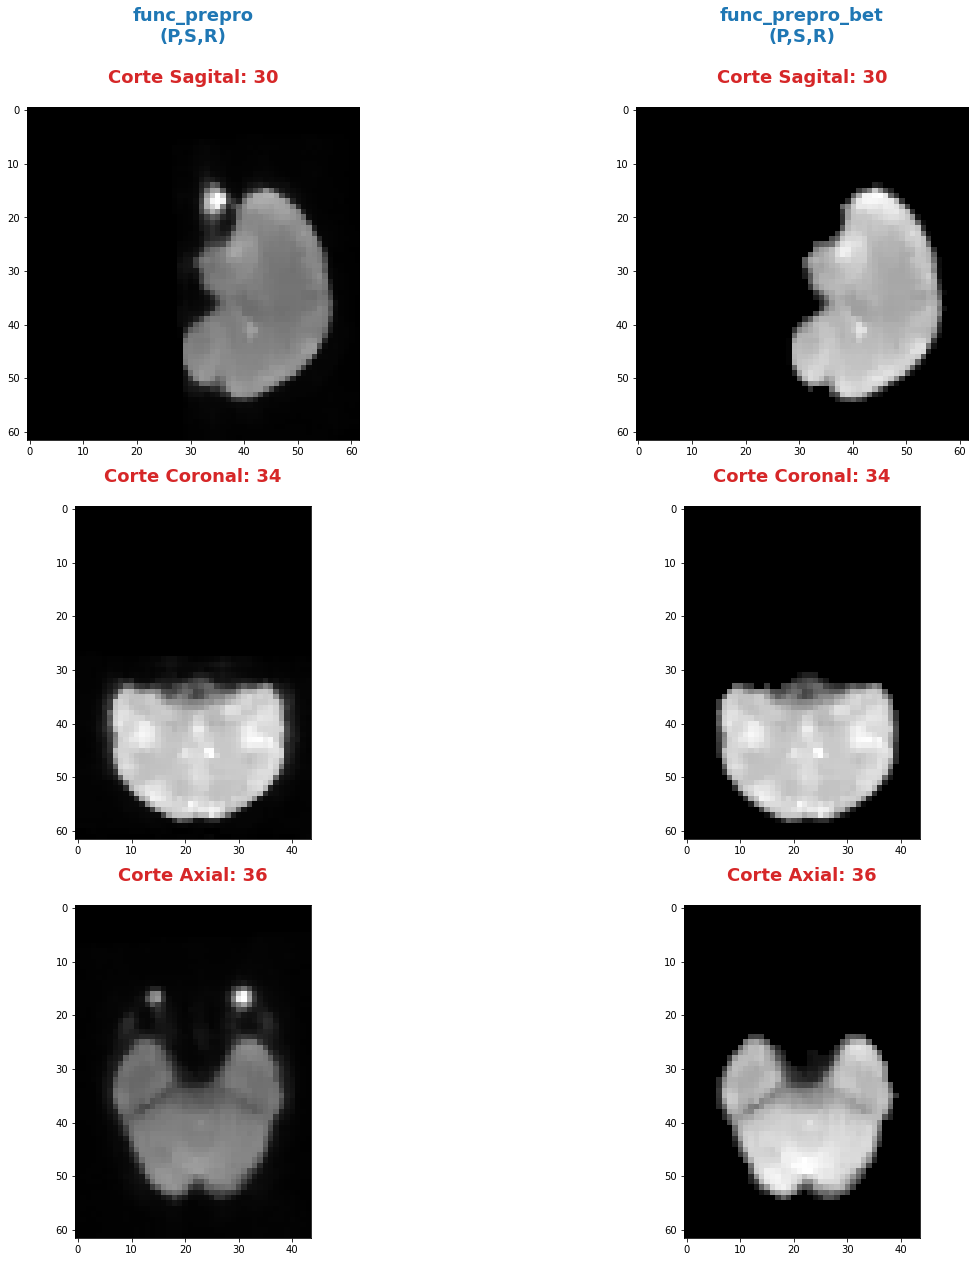

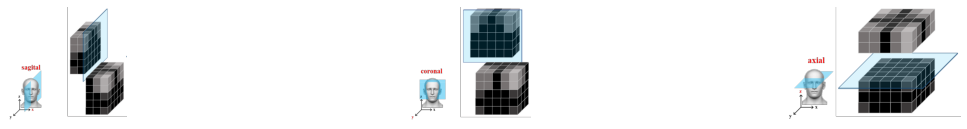

In [20]:
visual_cortes_ana(img=img_oribet,
                  vol=30,
                  voxel=(34,36,30))

## Zoom para comparara img_prepro e img_prepro_bet

,orientacion,x,y,z,volumen,valor_voxel
func_prepro,"(P,S,R)",30,16,34,10,952.101196
func_prepro_bet,"(P,S,R)",30,16,34,10,0.0


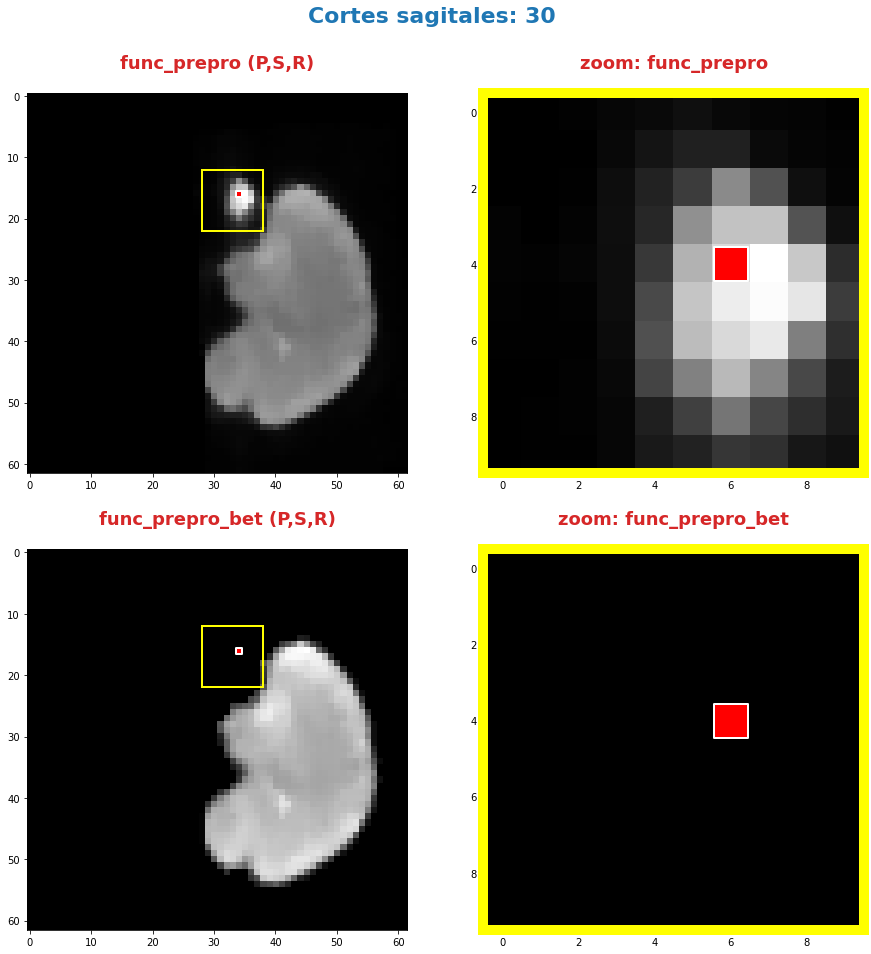

In [21]:
zoom_with_pto(img=img_oribet,
              vol=10,
              tipo='sagital',
              corte=30,
              ini_verti=12, 
              ini_hori=28,
              n=10,
              pto=(16,34)
             )

,orientacion,x,y,z,volumen,valor_voxel
func_prepro,"(P,S,R)",15,34,23,10,12.789221
func_prepro_bet,"(P,S,R)",15,34,23,10,0.0


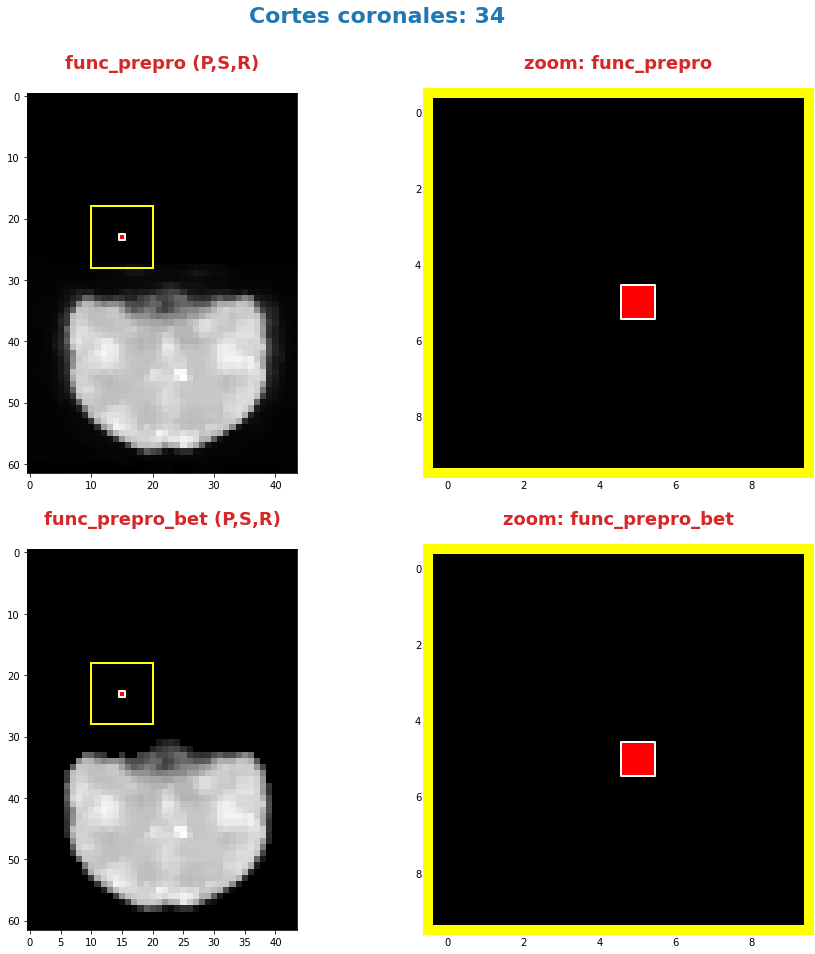

In [22]:
zoom_with_pto(img=img_oribet,
              vol=10,
              tipo='coronal',
              corte=34,
              ini_verti=18, 
              ini_hori=10,
              n=10,
              pto=(23,15)
             )

,orientacion,x,y,z,volumen,valor_voxel
func_prepro,"(P,S,R)",31,17,36,10,1079.920044
func_prepro_bet,"(P,S,R)",31,17,36,10,0.0


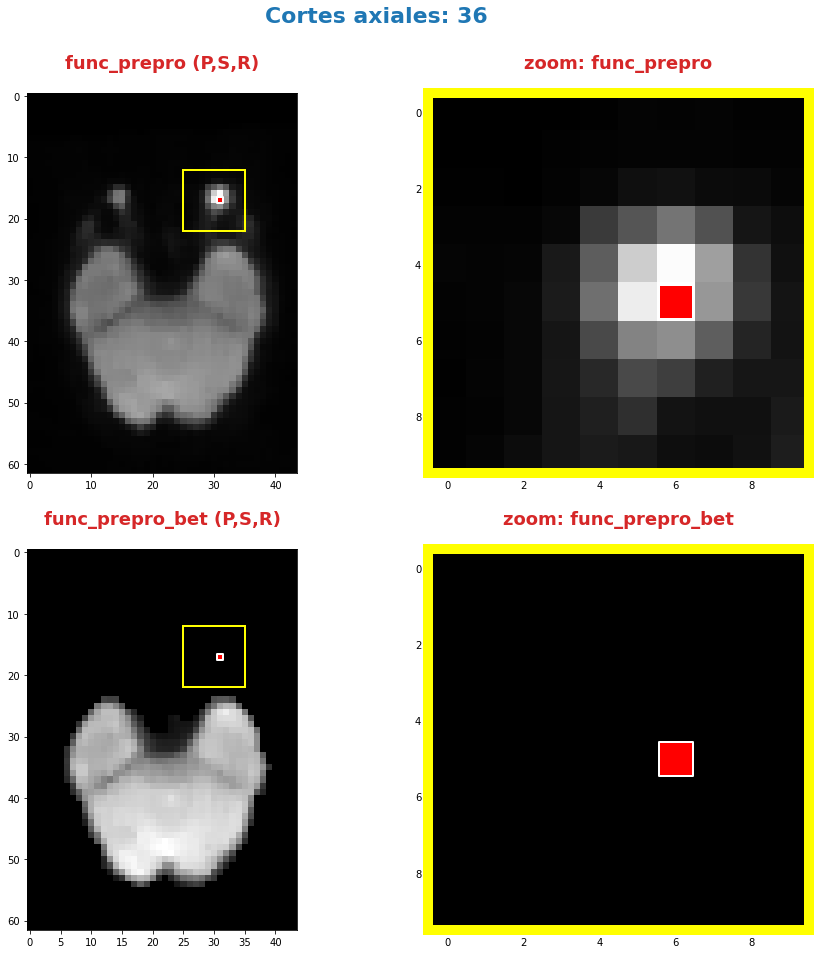

In [23]:
zoom_with_pto(img=img_oribet,
              vol=10,
              tipo='axial',
              corte=36,
              ini_verti=12, 
              ini_hori=25,
              n=10,
              pto=(17,31)
             )

## Aplicamos función atributos

In [24]:
atributo_img(img=img_oribet)

,func_prepro,func_prepro_bet
forma,"(62, 62, 44, 196)","(62, 62, 44, 196)"
dimension,4,4
orientacion,"(P, S, R)","(P, S, R)"
,"[y, z, x]","[y, z, x]"
x_img,44,44
y_img,62,62
z_img,62,62
volumenes_(N),196,196
voxel_size_(mm),"[4.0, 4.0, 4.0]","[4.0, 4.0, 4.0]"
TR_(s),3.56,3.56


## Tiempo de ejecución

In [25]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n\n', tiempo, 'seg\n', tiempo/60, 'min\n',      
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n\n', tiempo2, 'seg\n', tiempo2/60, 'min\n',   
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución

 11.309047937393188 seg
 0.18848413228988647 min
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU

 14.461932626 seg
 0.2410322104333333 min
 ---------------------------------------



## FIN